In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from PIL import Image, ImageDraw

## First, experiment whith generating region proposals

In [49]:
class EdgeBoxes():
    def __init__(self, model_path, max_boxes=30):
        self.edge_detection = cv.ximgproc.createStructuredEdgeDetection(model_path)
        self.edge_boxes = cv.ximgproc.createEdgeBoxes()
        self.edge_boxes.setMaxBoxes(30)

    def __call__(self, image, ret_scores=False):
        cv_img = image
        if not isinstance(image, torch.Tensor):
            cv_img = transforms.PILToTensor()(cv_img)
        cv_img = cv_img.permute((1,2,0)).numpy()
        rgb_im = cv.cvtColor(cv_img, cv.COLOR_BGR2RGB)
        edges = self.edge_detection.detectEdges(np.float32(rgb_im) / 255.0)
        orimap = self.edge_detection.computeOrientation(edges)
        edges = self.edge_detection.edgesNms(edges, orimap)
        boxes = self.edge_boxes.getBoundingBoxes(edges, orimap)

        # OpenCV returns (x, y, w, h). Shift to be (x1, y1, x2, y2)
        for b in boxes[0]:
            b[2] += b[0]
            b[3] += b[1]
            
        if ret_scores:
            return boxes[0], boxes[1]
        
        return boxes[0]

In [50]:
voc_set = datasets.VOCDetection('../../../data/', download=False)

In [51]:
image, label = voc_set[200]

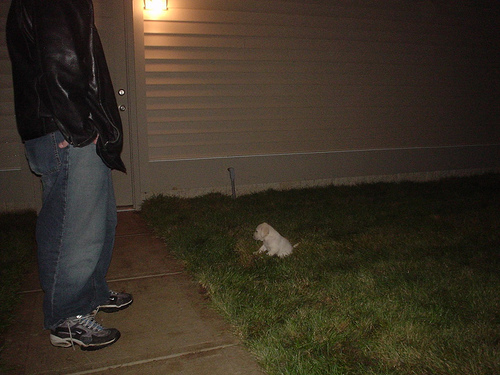

In [52]:
image

In [53]:
label

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000815.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '500', 'height': '375', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'person',
    'pose': 'Right',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '5', 'ymin': '1', 'xmax': '134', 'ymax': '351'},
    'difficult': '0'},
   {'name': 'dog',
    'pose': 'Left',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '252', 'ymin': '223', 'xmax': '301', 'ymax': '259'},
    'difficult': '0'}]}}

First, ensure that the boxes are generated correctly:

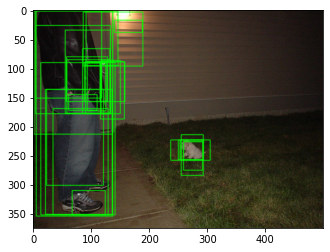

In [54]:
edge_boxes = EdgeBoxes('../edge_boxes_model/model.yml.gz')
boxes, scores = edge_boxes(image, ret_scores=True)
cv_img_drawn = transforms.PILToTensor()(image)
cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
for b in boxes:
    x1, y1, x2, y2 = b
    cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
plt.imshow(cv_img_drawn)

These look good! Next, try using pytorch's minumum suppression function, so we must convert things to tensors:

In [55]:
tensor_boxes = transforms.ToTensor()(boxes.astype('float')).view([len(scores), 4])
tensor_scores = transforms.ToTensor()(scores.astype('float')).view(-1)

In [56]:
scores

array([[0.10811982],
       [0.10758759],
       [0.08678046],
       [0.08440719],
       [0.08076631],
       [0.07862864],
       [0.07816822],
       [0.07556836],
       [0.07458514],
       [0.07384888],
       [0.07379994],
       [0.07210858],
       [0.07191011],
       [0.07050711],
       [0.06978725],
       [0.06944643],
       [0.06927944],
       [0.06927704],
       [0.068483  ],
       [0.06828517],
       [0.06821674],
       [0.06805006],
       [0.06751662],
       [0.06585152],
       [0.06571393],
       [0.06538977],
       [0.06499853],
       [0.06470788],
       [0.06468781],
       [0.06436561]], dtype=float32)

In [57]:
keep = torchvision.ops.nms(tensor_boxes, tensor_scores, 0.4).numpy()

In [58]:
keep

array([ 0,  2,  5,  7,  9, 10, 12, 15, 21, 25], dtype=int64)

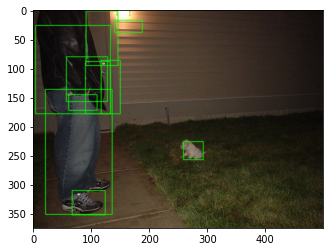

In [59]:
cv_img_drawn = transforms.PILToTensor()(image)
cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
for keep_idx in keep:
    x1, y1, x2, y2 = boxes[keep_idx]
    cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
plt.imshow(cv_img_drawn)


## Creating custom dataset object to also return these detections

In [121]:
class CustomVOC(datasets.VOCDetection):
    """Custom dataset that also generates boxes for each image"""
    def __init__(self, edge_model, eval_mode=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_boxes = EdgeBoxes(edge_model)
        self.label_names = [
            'background',
            'aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor'
        ]

        self.eval_mode = eval_mode

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        boxes = self.edge_boxes(image)
        boxes = transforms.ToTensor()(boxes.astype('float32')).view([len(boxes), 4])

        one_hot_label = torch.ones(len(self.label_names)) * -1
        for obj in label['annotation']['object']:
            one_hot_label[self.label_names.index(obj['name'])] = 1

        if torch.sum(one_hot_label) == -len(self.label_names):
            # Background
            one_hot_label[0] = 1


        if self.eval_mode:
            gt_boxes = []
            for obj in label['annotation']['object']:
                label_index = self.label_names.index(obj['name'])
                bbox = obj['bndbox']
                gt_boxes.append([
                    int(bbox['xmin']), 
                    int(bbox['ymin']), 
                    int(bbox['xmax']), 
                    int(bbox['ymax']), 
                    label_index, 
                    int(obj['difficult']), 
                    0
                ])

            return image, one_hot_label, boxes, gt_boxes

        return image, one_hot_label, boxes


    def format_pred(self, net_detections):
        """net_detections: the output of WSDDN.detect()"""
        boxes = []
        for label in net_detections.keys():
            for box in net_detections[label]:
                boxes.append([*box[1], label, box[0]])
        
        return boxes


    def draw_boxes(self, image, pred_boxes, gt_boxes):
        """
        GT: [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
        Pred: [xmin, ymin, xmax, ymax, class_id, confidence]
        """
        img = image
        if not isinstance(image, torch.Tensor):
            img = transforms.PILToTensor()(image)

        img = img.permute((1,2,0)).numpy()

        for b in pred_boxes:
            x1, y1, x2, y2, class_id, conf = b
            img = cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (255, 0, 0))

        for b in gt_boxes:
            x1, y1, x2, y2, class_id, _, _ = b
            img = cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
            label = self.label_names[class_id]
            img = self.draw_label(img, label, x1, y1, (0, 255, 0))

        return Image.fromarray(img)
    
    def draw_label(self, img, label, x1, y1, color):
        (label_width, label_height), baseline = cv.getTextSize(label, cv.FONT_HERSHEY_COMPLEX, 0.4, 1)
        back_tl = int(x1), int(y1 - int(1.3 * label_height))
        back_br = int(x1 + label_width), int(y1)
        cv.rectangle(img, back_tl, back_br, color, -1)
        txt_tl = int(x1), int(y1 - int(0.3 * label_height))
        return cv.putText(img, label, txt_tl, cv.FONT_HERSHEY_COMPLEX, 0.4, (0, 0, 0))


    def draw_raw_boxes(self, image, boxes):
        cv_img_drawn = transforms.PILToTensor()(image)
        cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
        for i, b in enumerate(boxes):
            x1, y1, x2, y2 = b
            cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)

        return Image.fromarray(cv_img_drawn)

In [122]:
custom_voc_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False)

In [62]:
len(custom_voc_set.label_names)

21

In [123]:
img, label, boxes = custom_voc_set[2]

In [117]:
label

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
        -1., -1., -1., -1., -1., -1., -1.])

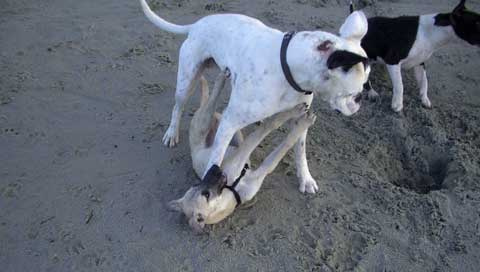

In [118]:
img

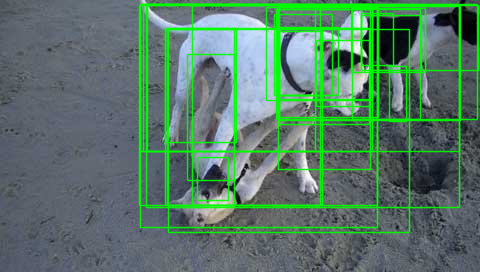

In [125]:
custom_voc_set.draw_raw_boxes(img, list(boxes.numpy().astype('int')))

Experiment with the correct way to crop the image using splicing of tensors

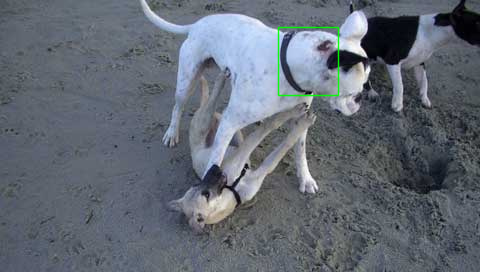

In [126]:
cv_img_drawn = transforms.PILToTensor()(img)
cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
x1, y1, x2, y2 = boxes[2]
cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
Image.fromarray(cv_img_drawn)

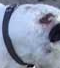

In [129]:
img_tensor = transforms.PILToTensor()(img)
transforms.ToPILImage()(img_tensor[:, int(y1):int(y2), int(x1):int(x2)]) # Note that x,y are flipped

Next, see how to get the VGG feature extractor, pretrained on ImageNet

In [130]:
vgg_backbone = torchvision.models.vgg16(pretrained=True)

In [131]:
vgg_backbone

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Creating the Model

In [132]:
from collections import OrderedDict

In [133]:
class WSDDN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        vgg_backbone = torchvision.models.vgg16(pretrained=True)
        self.features = vgg_backbone.features[:-1]
        self.fcs = vgg_backbone.classifier[:-1] # 25088 -> 4096
        # Class level (_c) and detection level (_d) layers
        self.fc_c = nn.Linear(4096, num_classes)
        self.fc_d = nn.Linear(4096, num_classes)


    def forward(self, x, boxes):
        x = self.features(x)
        x = torchvision.ops.roi_pool(x, [boxes], (7,7), 1.0 / 16)
        x = x.view(x.shape[0], -1)

        x = self.fcs(x)
        
        
        x_c = F.softmax(self.fc_c(x), dim=1)
        x_d = F.softmax(self.fc_d(x), dim=0)

        scores = x_c * x_d
        
        # Return final score and FC7 output, for reg. purposes
        return scores, x

    def detect(self, x, boxes):
        scores, _ = self.forward(x, boxes)

        num_boxes = len(boxes[0])
        num_classes = scores.shape[1]
        ranked_box_list = [OrderedDict() for _ in range(num_classes)]
        r_c_scores = torch.argmax(scores, dim=1)
        for i in range(num_boxes):
            score_idx = r_c_scores[i]
            ranked_box_list[score_idx][float(scores[i, score_idx].detach().numpy())] = list(boxes[i].numpy())

        predict_boxes = {}
        for cls_index, ranked_boxes in enumerate(ranked_box_list):
            if len(ranked_boxes) == 0:
                continue
            scores = np.array([list(ranked_boxes.keys())]).T
            bboxes = np.array(list(ranked_boxes.values()))
            tensor_boxes = transforms.ToTensor()(bboxes.astype('float')).view([len(scores), 4])
            tensor_scores = transforms.ToTensor()(scores.astype('float')).view(-1)
            keep = torchvision.ops.nms(tensor_boxes, tensor_scores, 0.4).numpy()
            keep_boxes = []
            ranked_boxes_items = list(ranked_boxes.items())
            for i in keep:
                keep_boxes.append(ranked_boxes_items[i])
            predict_boxes[cls_index] = keep_boxes
        
        return predict_boxes

        
    @staticmethod
    def loss(combined_scores, target):
        image_level_scores = torch.sum(combined_scores, dim=0)
        image_level_scores = torch.clamp(image_level_scores, min=0.0, max=1.0)
        loss = F.binary_cross_entropy(image_level_scores, target, reduction="sum")
        return loss
    
    @staticmethod
    def reg(scores, fc7):
        class_scores = torch.argmax(scores, dim=0)
        num_classes = class_scores.shape[0]
        reg = 0
        for k in range(num_classes):
            # For each class, grab the highest scoring region
            highest_region = class_scores[k]
            highest_score = forward[highest_region, k]
            # Get any regions with IOU > 0.6
            overlap_idxs = (torchvision.ops.box_iou(boxes_tensor[highest_region].reshape(1, 4), boxes_tensor) > 0.6)[0]
            for r in list(torch.where(overlap_idxs)[0]):
                # For each region in the high overlapping ones
                diff = fc7[highest_region] - fc7[r]
                reg += torch.pow(highest_score, 2) * torch.matmul(diff.T, diff) / 2
        
        return reg / num_classes

    def spatial_pyramid_pool(self, previous_conv, num_sample, previous_conv_size, out_pool_size):
        # Source: https://github.com/yueruchen/sppnet-pytorch/blob/master/cnn_with_spp.py
        '''
        previous_conv: a tensor vector of previous convolution layer
        num_sample: an int number of image in the batch
        previous_conv_size: an int vector [height, width] of the matrix features size of previous convolution layer
        out_pool_size: a int vector of expected output size of max pooling layer
        
        returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
        '''    
        # print(previous_conv.size())
        for i in range(len(out_pool_size)):
            # print(previous_conv_size)
            h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
            w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
            h_pad = (h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2
            w_pad = (w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2
            maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(h_pad, w_pad))
            x = maxpool(previous_conv)
            if (i == 0):
                spp = x.view(num_sample,-1)
                # print("spp size:",spp.size())
            else:
                # print("size:",spp.size())
                spp = torch.cat((spp,x.view(num_sample,-1)), 1)
        
        return spp

In [134]:
custom_voc_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False, image_set='train')

In [135]:
image, label, boxes = custom_voc_set[1]

In [136]:
image_tensor = transforms.ToTensor()(image)
image_tensor = image_tensor.reshape([1, image_tensor.shape[0], image_tensor.shape[1], image_tensor.shape[2]])

In [137]:
net = WSDDN(21)
forward, x = net(image_tensor, boxes)
forward.shape

torch.Size([30, 21])

In [1]:
Now that a forward pass works successfully, try out some of the code to get per-class detections. Note this is pretty much jus tnoise right now, as the model is untrained

In [138]:
torch.argmax(forward, dim=0)

tensor([20, 18, 20, 14, 11, 17, 12,  9,  3, 26, 20, 21, 17,  7, 16, 24, 24, 12,
        20, 27,  8])

Pick a random box and use its class

In [139]:
ious = torchvision.ops.box_iou(boxes[3].reshape(1, 4), boxes)

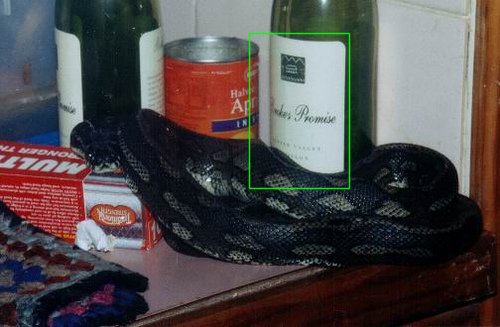

In [141]:
custom_voc_set.draw_raw_boxes(image, [boxes[3]])

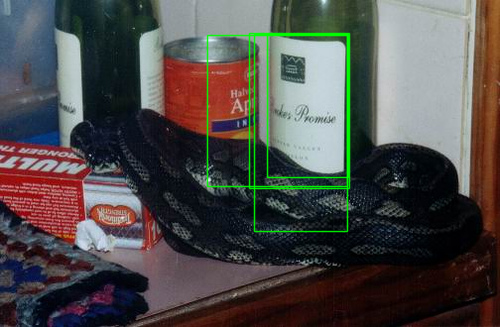

In [142]:
custom_voc_set.draw_raw_boxes(image, boxes[(ious > 0.6)[0]])

In [143]:
torch.argmax(forward, dim = 0)

tensor([20, 18, 20, 14, 11, 17, 12,  9,  3, 26, 20, 21, 17,  7, 16, 24, 24, 12,
        20, 27,  8])

In [144]:
x.shape

torch.Size([30, 4096])

In [145]:
torch.argmax(forward, dim=0)
ious = torchvision.ops.box_iou(boxes[3].reshape(1, 4), boxes)

In [146]:
x[0].shape

torch.Size([4096])

In [147]:
torch.sum((ious > 0.6)[0])

tensor(4)

In [148]:
class_scores = torch.argmax(forward, dim=0)
reg = 0
for k in range(21):
    # For each class, grab the highest scoring region
    highest_region = class_scores[k]
    highest_score = forward[highest_region, k]
    # Get any regions with IOU > 0.6
    overlap_idxs = (torchvision.ops.box_iou(boxes_tensor[highest_region].reshape(1, 4), boxes_tensor) > 0.6)[0]
    for r in list(torch.where(overlap_idxs)[0]):
        # For each region in the high overlapping ones
        diff = x[highest_region] - x[r]
        reg += torch.pow(highest_score, 2) * torch.matmul(diff.T, diff) / 2
reg /= 21

In [149]:
reg

tensor(0.1118, grad_fn=<DivBackward0>)

In [150]:
net.reg(forward, x)

tensor(0.1118, grad_fn=<DivBackward0>)

Test working with batches within a DataLoader

In [151]:
transform_train = transforms.Compose([
    transforms.PILToTensor(),
])

def my_collate(batch):
    data = [item[0] for item in batch]
    label = [item[1] for item in batch]
    return [data, label]

train_set = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False, image_set='train', transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=0, collate_fn=my_collate)

In [152]:
for i, data in enumerate(train_loader):
    imgs, labels = data
    print(imgs[0].shape)
    print(imgs[1].shape)
    if i == 10:
        break

torch.Size([3, 338, 500])
torch.Size([3, 500, 377])
torch.Size([3, 375, 500])
torch.Size([3, 375, 500])
torch.Size([3, 375, 500])
torch.Size([3, 500, 333])
torch.Size([3, 500, 375])
torch.Size([3, 375, 500])
torch.Size([3, 375, 500])
torch.Size([3, 375, 500])
torch.Size([3, 333, 500])
torch.Size([3, 500, 469])
torch.Size([3, 375, 500])
torch.Size([3, 375, 500])
torch.Size([3, 375, 500])
torch.Size([3, 334, 500])
torch.Size([3, 335, 500])
torch.Size([3, 375, 500])
torch.Size([3, 500, 375])
torch.Size([3, 375, 500])
torch.Size([3, 332, 500])
torch.Size([3, 500, 375])


In [153]:
imgs[0].shape

torch.Size([3, 332, 500])

In [154]:
imgs[1].shape

torch.Size([3, 500, 375])

## Evaluation

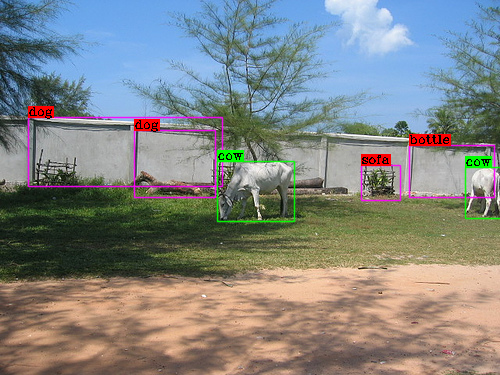

In [155]:
custom_voc_set_eval = CustomVOC('../edge_boxes_model/model.yml.gz', root='../../../data/', download=False, eval_mode=True, image_set='val')
net.eval()
image, label, boxes, gt_boxes = custom_voc_set_eval[3]
image_tensor = transforms.ToTensor()(image)
image_tensor = image_tensor.reshape([1, image_tensor.shape[0], image_tensor.shape[1], image_tensor.shape[2]])
detections = net.detect(image_tensor, boxes)
formatted_detections = custom_voc_set_eval.format_pred(detections)
custom_voc_set_eval.draw_boxes(image, formatted_detections, gt_boxes)

In [156]:
from mean_average_precision import MetricBuilder
# NOTE: Had to pip install the newest version from git (pip install --upgrade git+https://github.com/bes-dev/mean_average_precision.git)

In [157]:
metric_fn = MetricBuilder.build_evaluation_metric("map_2d", num_classes=21)
metric_fn.add(np.array(formatted_detections), np.array(gt_boxes))

In [158]:
print(f"VOC PASCAL mAP: {metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']}")

VOC PASCAL mAP: 0.0


In [160]:
metric_fn.value(iou_thresholds=0.5, recall_thresholds=np.arange(0., 1.1, 0.1))['mAP']

0.0